In [20]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import PIL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True

## Initializing Dataset

In [2]:
# Define the directories
train_dir = '../data/train'
valid_dir = '../data/valid'
test_dir = '../data/test'

In [3]:
img_transform = transforms.Compose([
    transforms.Resize((64, 64)), # resizes to 64x64
    transforms.ToTensor(),   # convert image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize
])

In [4]:
# initializes dataset from training directory
train_dataset = ImageFolder(root=train_dir, transform = img_transform)
valid_dataset = ImageFolder(root=valid_dir, transform = img_transform)


# creates dataloader over dataset
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 16, shuffle = False)

In [5]:
data_iter = iter(train_dataloader)
images, labels = next(data_iter)
print(images.shape, labels)

torch.Size([16, 3, 64, 64]) tensor([1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0])


## First Models

In [10]:
# initialize CNN model
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size = 3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size = 3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32*16*16, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

In [11]:
model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=8192, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
  (10): Sigmoid()
)

In [12]:

criterion = nn.BCELoss()  # Loss function for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=8192, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
  (10): Sigmoid()
)

In [29]:
def train_one_epoch(epoch):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).float()

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images).squeeze()  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item()

        predicted = (outputs > 0.5).float()  # Convert to 0 or 1 based on threshold
        correct += (predicted.squeeze() == labels).sum().item()
        total += labels.size(0)
        
    model.eval() # set model to evaluation mode

    valid_running_loss = 0.0
    valid_correct = 0
    valid_total = 0 
    
    for images, labels in valid_dataloader: # iterate over validation dataset
        images, labels = images.to(device), labels.to(device).float()

        outputs = model(images).squeeze() # forward pass on validation dataset
        loss = criterion(outputs, labels)  # Compute the loss        
        valid_running_loss += loss.item()

        predicted = (outputs > 0.5).float()  # Convert to 0 or 1 based on threshold
        valid_correct += (predicted.squeeze() == labels).sum().item()
        valid_total += labels.size(0)
        
    avg_loss = running_loss / len(train_dataloader)
    accuracy = 100 * correct / total

    avg_valid_loss = valid_running_loss / len(valid_dataloader)
    valid_accuracy = 100 * valid_correct / valid_total
    #print(f"Train Loss: {avg_loss:.4f}")
    print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    print(f"Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")
    return [avg_loss, accuracy, avg_valid_loss, valid_accuracy]


In [30]:
df_train_loss = pd.DataFrame(columns = ['train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    df_train_loss.loc[epoch] = train_one_epoch(epoch)

Epoch 1/10: 100%|███████████████████████████| 1891/1891 [01:01<00:00, 30.88it/s]


Train Loss: 0.1025, Train Accuracy: 96.21%
Valid Loss: 0.1223, Valid Accuracy: 95.94%


Epoch 2/10: 100%|███████████████████████████| 1891/1891 [01:04<00:00, 29.49it/s]


Train Loss: 0.0824, Train Accuracy: 97.02%
Valid Loss: 0.1436, Valid Accuracy: 96.10%


Epoch 3/10: 100%|███████████████████████████| 1891/1891 [01:05<00:00, 28.92it/s]


Train Loss: 0.0653, Train Accuracy: 97.72%
Valid Loss: 0.1734, Valid Accuracy: 95.13%


Epoch 4/10: 100%|███████████████████████████| 1891/1891 [01:06<00:00, 28.23it/s]


Train Loss: 0.0472, Train Accuracy: 98.33%
Valid Loss: 0.1694, Valid Accuracy: 95.46%


Epoch 5/10: 100%|███████████████████████████| 1891/1891 [01:07<00:00, 27.97it/s]


Train Loss: 0.0391, Train Accuracy: 98.68%
Valid Loss: 0.2598, Valid Accuracy: 95.49%


Epoch 6/10: 100%|███████████████████████████| 1891/1891 [01:07<00:00, 27.82it/s]


Train Loss: 0.0333, Train Accuracy: 98.86%
Valid Loss: 0.2405, Valid Accuracy: 95.62%


Epoch 7/10: 100%|███████████████████████████| 1891/1891 [01:08<00:00, 27.45it/s]


Train Loss: 0.0278, Train Accuracy: 99.08%
Valid Loss: 0.2265, Valid Accuracy: 95.38%


Epoch 8/10: 100%|███████████████████████████| 1891/1891 [01:06<00:00, 28.30it/s]


Train Loss: 0.0255, Train Accuracy: 99.25%
Valid Loss: 0.3008, Valid Accuracy: 94.43%


Epoch 9/10: 100%|███████████████████████████| 1891/1891 [01:05<00:00, 28.84it/s]


Train Loss: 0.0234, Train Accuracy: 99.32%
Valid Loss: 0.3535, Valid Accuracy: 95.60%


Epoch 10/10: 100%|██████████████████████████| 1891/1891 [01:06<00:00, 28.50it/s]


Train Loss: 0.0240, Train Accuracy: 99.41%
Valid Loss: 0.2844, Valid Accuracy: 94.83%


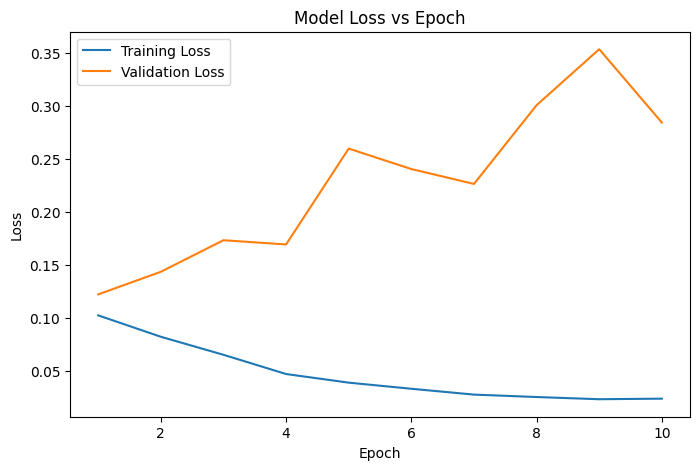

In [33]:
fig = plt.figure(figsize = (8,5))
plt.plot(list(range(1, num_epochs + 1)), df_train_loss['train_loss'], label = 'Training Loss')
plt.plot(list(range(1, num_epochs + 1)), df_train_loss['valid_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss vs Epoch')
plt.legend()
plt.show()

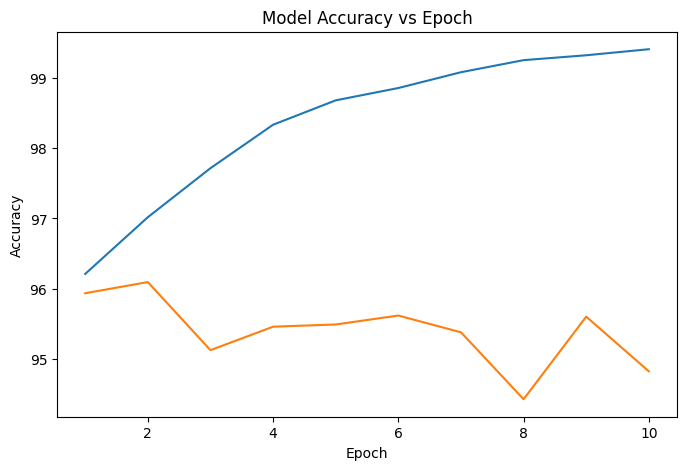

In [34]:
fig = plt.figure(figsize = (8,5))
plt.plot(list(range(1, num_epochs + 1)), df_train_loss['train_accuracy'], label = 'Training Accuracy')
plt.plot(list(range(1, num_epochs + 1)), df_train_loss['valid_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Epoch')
plt.show()

In [14]:
#torch.save(model.state_dict(), "../models/test_model_00.pt")